In [ ]:
from DataParser import get_df_list2
from Filter import filter_dataframes
from Interpolate import cubic_interpolation_padded
from sklearn.preprocessing import StandardScaler
from Scaler import preprocess_signals
from CreateTable import create_df

# dfs containing only the signals captured when the machine is touching
df_list = get_df_list2()
filter_dataframes(df_list, win_size=20, alpha=8)
interpolated = cubic_interpolation_padded(df_list, 0.003)
scaler = StandardScaler()
X_train, all_signals = preprocess_signals(interpolated, scaler)

print(X_train.shape)

In [ ]:
df_table = create_df()
df_table2 = df_table.drop(index=[2222, 3690])
df_table2 = df_table2.reset_index(drop=True)
labels = list(df_table2['label'])

In [ ]:
import random
import matplotlib.pyplot as plt

# Randomly select 40 DataFrames from df_list and add the max Energy df
sampled_dfs = random.sample(interpolated, 40)
fig, ax = plt.subplots(ncols=2)

for df in sampled_dfs:
    df.plot(x='t', y='Fz',
            color='gray',  # Set color to gray
            alpha=0.5,  # Add some transparency
            linewidth=0.4,  # Very thin lines
            legend=False,  # Don't show legend for each line
            ax=ax[0])  # Use the same axis

plt.xlabel('t')
plt.ylabel('Fz')

for df in sampled_dfs:
    df.plot(x='t', y='posz',
            color='gray',  # Set color to gray
            alpha=0.5,  # Add some transparency
            linewidth=0.4,  # Very thin lines
            legend=False,  # Don't show legend for each line
            ax=ax[1])  # Use the same axis

plt.xlabel('t')
plt.ylabel('posz')

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

classifier = tf.keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),

    layers.Conv1D(filters=16, kernel_size=32, activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2),

    layers.Conv1D(filters=32, kernel_size=16, activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2),

    layers.Conv1D(filters=64, kernel_size=12, activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=8, activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=2),
    
    layers.Conv1D(filters=256, kernel_size=4, activation='relu'),
    # layers.BatchNormalization(),
    
    # layers.Flatten(),
    layers.GlobalAveragePooling1D(),    

    # Dense layers with regularization
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.2),
    # layers.BatchNormalization(), 

    layers.Dense(32, activation='relu'),
    # layers.Dropout(0.2),
    # layers.BatchNormalization(),
        
    layers.Dense(16, activation='relu'),

    layers.Dense(6, activation='softmax')
])

# Compile the model
classifier.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical_cross entropy for multi-class classification
    metrics=['accuracy']
)

# Display model summary
classifier.summary()

In [ ]:
from sklearn.model_selection import train_test_split

# This ensures class proportions are maintained in both sets
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train,
    np.array(labels),
    test_size=0.3,
    random_state=42,
    stratify=np.array(labels)  # Maintains class distribution
)

In [ ]:
from plot_learning_class import PlotLearning
from tensorflow.keras.callbacks import ModelCheckpoint

# Calculate class weights inversely proportional to class frequencies
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_new), y=y_train_new)
class_weight_dict = dict(zip(np.unique(y_train_new), class_weights))
print("Class weights:", class_weight_dict)


early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=False, monitor="val_loss",
                                                  mode="min")
checkpoint_callback = ModelCheckpoint(filepath='weights/classifier.weights.h5', save_best_only=True,
                                      monitor="val_loss",
                                      mode='min', save_weights_only=True)

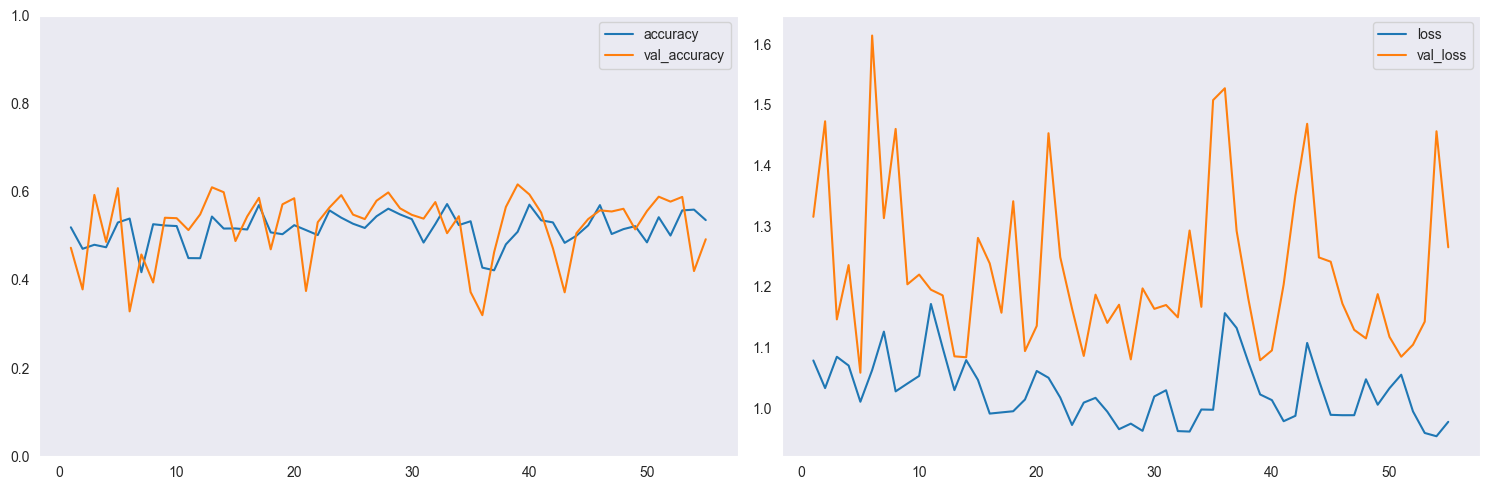

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.5078 - loss: 0.9778 - val_accuracy: 0.4924 - val_loss: 1.2652


In [88]:
history = classifier.fit( 
    X_train_new, tf.keras.utils.to_categorical(y_train_new, num_classes=6),
    epochs=500,
    batch_size=512,
    verbose=1,
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=6)),
    callbacks=[early_stopping, checkpoint_callback, PlotLearning(classifier)],
    class_weight=class_weight_dict
)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


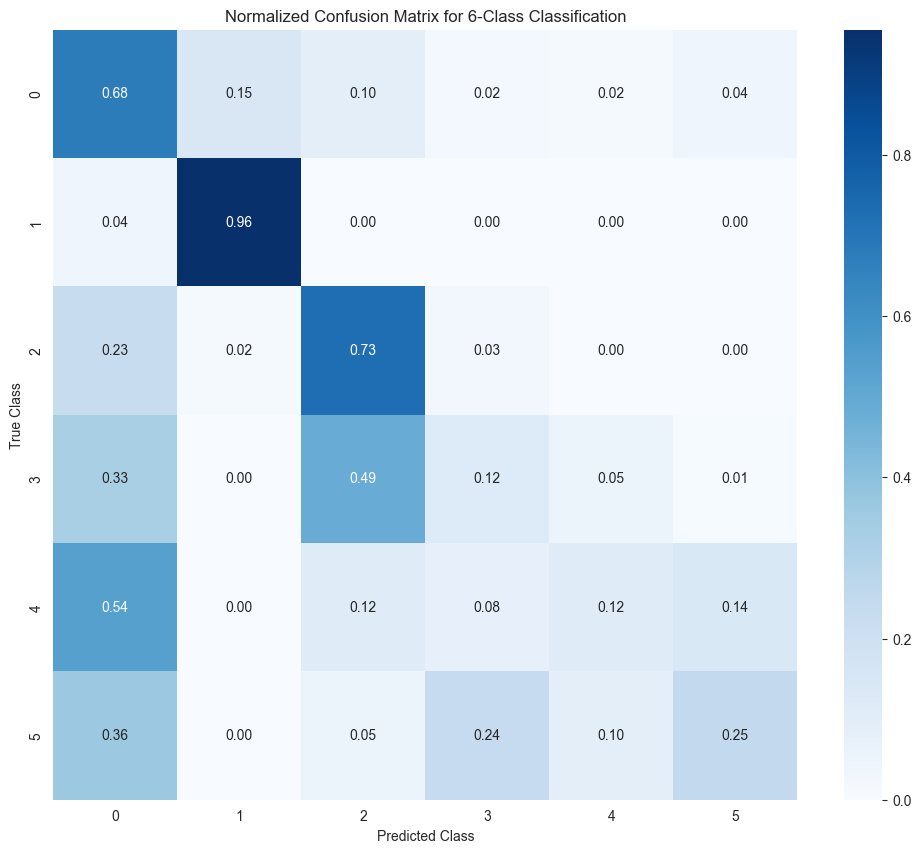

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

classifier.load_weights('weights/classifier.weights.h5')

# Generate predictions
y_val_pred_probs = classifier.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)  # Convert probabilities to class labels

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# If you want percentages instead of counts
cm_normalized = confusion_matrix(y_val, y_val_pred, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(6),
            yticklabels=range(6))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix for 6-Class Classification')
plt.savefig('normalized_confusion_matrix_6_classes.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
y_val_pred_probs = classifier.predict(X_train_new)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)  # Convert probabilities to class labels

# Create confusion matrix
cm = confusion_matrix(y_train_new, y_val_pred)

# If you want percentages instead of counts
cm_normalized = confusion_matrix(y_train_new, y_val_pred, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(6),
            yticklabels=range(6))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix for 6-Class Classification')
plt.savefig('normalized_confusion_matrix_6_classes.png', dpi=300, bbox_inches='tight')
plt.show()